# Continual Learning


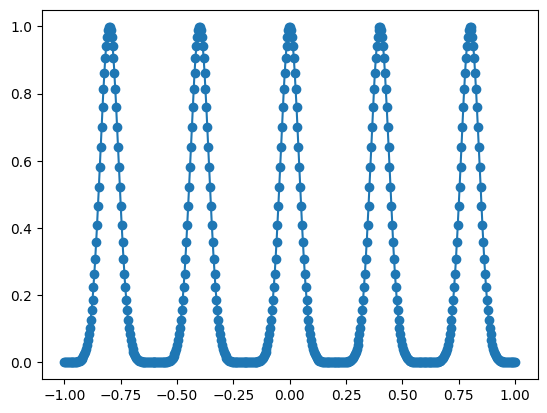

In [1]:
from lkan.models import KAN, MLP
import numpy as np
import torch
import matplotlib.pyplot as plt

datasets = []

n_peak = 5
n_num_per_peak = 100
n_sample = n_peak * n_num_per_peak

x_grid = torch.linspace(-1, 1, steps=n_sample)

x_centers = 2 / n_peak * (np.arange(n_peak) - n_peak / 2 + 0.5)

x_sample = torch.stack(
    [
        torch.linspace(-1 / n_peak, 1 / n_peak, steps=n_num_per_peak) + center
        for center in x_centers
    ]
).reshape(
    -1,
)


y = 0.0
for center in x_centers:
    y += torch.exp(-((x_grid - center) ** 2) * 300)

y_sample = 0.0
for center in x_centers:
    y_sample += torch.exp(-((x_sample - center) ** 2) * 300)


plt.plot(x_grid.detach().numpy(), y.detach().numpy())
plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())

Sequentially prensenting different peaks to KAN


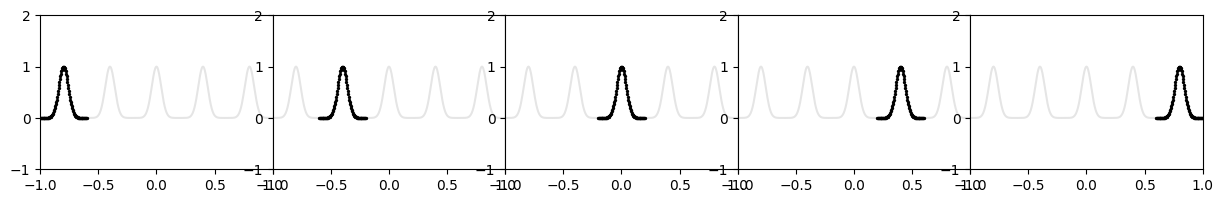

In [2]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1, 6):
    plt.subplot(1, 5, i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color="black", alpha=0.1)
    plt.scatter(
        x_sample[group_id * n_num_per_peak : (group_id + 1) * n_num_per_peak]
        .detach()
        .numpy(),
        y_sample[group_id * n_num_per_peak : (group_id + 1) * n_num_per_peak]
        .detach()
        .numpy(),
        color="black",
        s=2,
    )
    plt.xlim(-1, 1)
    plt.ylim(-1, 2)

In [3]:
def train(model, x, y, steps=100, lr=1.0):
    opt = torch.optim.LBFGS(model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32)
    
    for step in range(steps):
        def closure():
            opt.zero_grad()
            loss = torch.nn.functional.mse_loss(model(x), y)
            loss.backward()
            return loss

        opt.step(closure)
        print(f"step: {step}, loss: {torch.nn.functional.mse_loss(model(x), y)}")

Training KAN


In [10]:
# FFT version

ys = []

model = KAN([1, 1], grid_size=200, noise_scale=0.1, device="cpu", kan_layer_version="fft", bias=False, scale_spline_trainable=False, scale_base_trainable=False)

for group_id in range(n_peak):
    x_ds = x_sample[group_id * n_num_per_peak : (group_id + 1) * n_num_per_peak][:, None]
    y_ds = y_sample[group_id * n_num_per_peak : (group_id + 1) * n_num_per_peak][:, None]
    train(model, x_ds, y_ds, steps=10)
    y_pred = model(x_grid[:,None])
    ys.append(y_pred.detach().numpy()[:,0])

step: 0, loss: 2.8063928425581253e-07
step: 1, loss: 9.130032729842696e-09
step: 2, loss: 8.806139817352232e-09
step: 3, loss: 8.806139817352232e-09
step: 4, loss: 8.806139817352232e-09
step: 5, loss: 8.806139817352232e-09
step: 6, loss: 8.806139817352232e-09
step: 7, loss: 8.806139817352232e-09
step: 8, loss: 8.806139817352232e-09
step: 9, loss: 8.806139817352232e-09
step: 0, loss: 8.061586527219333e-07
step: 1, loss: 4.7110425782648235e-08
step: 2, loss: 2.9275368795822487e-09
step: 3, loss: 2.9173663484982626e-09
step: 4, loss: 2.9173663484982626e-09
step: 5, loss: 2.9173663484982626e-09
step: 6, loss: 2.9173663484982626e-09
step: 7, loss: 2.9173663484982626e-09
step: 8, loss: 2.9173663484982626e-09
step: 9, loss: 2.9173663484982626e-09
step: 0, loss: 9.975335224510218e-09
step: 1, loss: 8.521977790110213e-09
step: 2, loss: 7.954072067661855e-09
step: 3, loss: 1.239623959037317e-09
step: 4, loss: 1.237471014547964e-09
step: 5, loss: 1.237471014547964e-09
step: 6, loss: 1.23747101454

In [8]:
# "1" version

ys = []

model = KAN([1, 1], grid_size=200, k=3, noise_scale=0.1, device="cpu", kan_layer_version="1", bias=False, scale_spline_trainable=False, scale_base_trainable=False)

for group_id in range(n_peak):
    x_ds = x_sample[group_id * n_num_per_peak : (group_id + 1) * n_num_per_peak][:, None]
    y_ds = y_sample[group_id * n_num_per_peak : (group_id + 1) * n_num_per_peak][:, None]
    train(model, x_ds, y_ds, steps=10)
    y_pred = model(x_grid[:,None])
    ys.append(y_pred.detach().numpy()[:,0])

step: 0, loss: 7.989606274350081e-07
step: 1, loss: 2.7133429184034163e-11
step: 2, loss: 1.6106454711617424e-11
step: 3, loss: 1.6105634187413287e-11
step: 4, loss: 1.6105634187413287e-11
step: 5, loss: 1.6105634187413287e-11
step: 6, loss: 1.6105634187413287e-11
step: 7, loss: 1.6105634187413287e-11
step: 8, loss: 1.6105634187413287e-11
step: 9, loss: 1.6105634187413287e-11
step: 0, loss: 3.0838197062621475e-07
step: 1, loss: 3.301015363832427e-11
step: 2, loss: 2.5606339965067448e-11
step: 3, loss: 2.4824475808316038e-11
step: 4, loss: 2.4824475808316038e-11
step: 5, loss: 2.4824475808316038e-11
step: 6, loss: 2.4824475808316038e-11
step: 7, loss: 2.4824475808316038e-11
step: 8, loss: 2.4824475808316038e-11
step: 9, loss: 2.4824475808316038e-11
step: 0, loss: 2.344881977478508e-08
step: 1, loss: 2.6667969915683543e-11
step: 2, loss: 2.4494477626757494e-11
step: 3, loss: 2.4494477626757494e-11
step: 4, loss: 2.4494477626757494e-11
step: 5, loss: 2.4494477626757494e-11
step: 6, loss: 

In [39]:
# MLP version

ys = []

model = MLP([1,3000,10,3000,1], device="cpu")

for group_id in range(n_peak):
    x_ds = x_sample[group_id * n_num_per_peak : (group_id + 1) * n_num_per_peak][:, None]
    y_ds = y_sample[group_id * n_num_per_peak : (group_id + 1) * n_num_per_peak][:, None]
    train(model, x_ds, y_ds, steps=10)
    y_pred = model(x_grid[:,None])
    ys.append(y_pred.detach().numpy()[:,0])

step: 0, loss: 0.11297139525413513
step: 1, loss: 0.04465113580226898
step: 2, loss: 0.008922244422137737
step: 3, loss: 0.002126624109223485
step: 4, loss: 0.0017100253608077765
step: 5, loss: 0.0010833177948370576
step: 6, loss: 0.0009984661592170596
step: 7, loss: 0.0009661344229243696
step: 8, loss: 0.0007442286587320268
step: 9, loss: 0.0005842092214152217
step: 0, loss: 0.016968853771686554
step: 1, loss: 0.002908227499574423
step: 2, loss: 0.000797101529315114
step: 3, loss: 0.00016631763719487935
step: 4, loss: 7.839404133846983e-05
step: 5, loss: 7.786348578520119e-05
step: 6, loss: 7.786348578520119e-05
step: 7, loss: 7.786348578520119e-05
step: 8, loss: 7.786348578520119e-05
step: 9, loss: 7.786348578520119e-05
step: 0, loss: 0.040860194712877274
step: 1, loss: 0.004297345411032438
step: 2, loss: 0.0008208941435441375
step: 3, loss: 0.0002208142395829782
step: 4, loss: 0.00014800090866629034
step: 5, loss: 9.727204451337457e-05
step: 6, loss: 8.837518544169143e-05
step: 7, l

Prediction of KAN after each stage


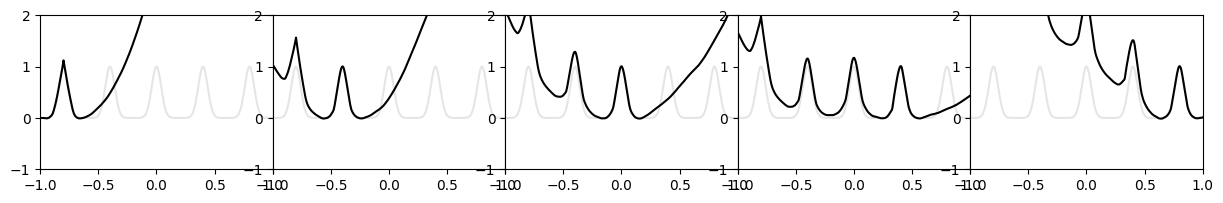

In [40]:
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1, 6):
    plt.subplot(1, 5, i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color="black", alpha=0.1)
    plt.plot(x_grid.detach().numpy(), ys[i - 1], color="black")
    plt.xlim(-1, 1)
    plt.ylim(-1, 2)